In [1]:
!pip install neuralforecast

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.8/141.8 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.0/719.0 kB 23.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.6/58.6 MB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 39.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 81.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 51.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.5/468.5 kB 40.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from neuralforecast import NeuralForecast
from neuralforecast.models import NBEATSx
from neuralforecast.losses.pytorch import MQLoss, DistributionLoss, MSE, MAE
from neuralforecast.tsdataset import TimeSeriesDataset, TimeSeriesLoader
from numpy.random import seed
from random import randrange
from neuralforecast.losses.numpy import rmse, mape
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
from neuralforecast.utils import AirPassengers, AirPassengersPanel, AirPassengersStatic

In [3]:
df = pd.read_excel("DJIA RV.xlsx",index_col='Date',parse_dates=True)

In [4]:
df.reset_index(inplace=True)
df.rename(columns={'Date':'ds'}, inplace=True)
df.rename(columns={'RV':'y'}, inplace=True)
df.drop(columns=["wasserstein_dists_2D"], inplace=True)
df["unique_id"]="airplane1"
train = df.iloc[:int(len(df['y'])*0.8)]
test = df.iloc[int(len(df['y'])*0.8):]
validation_length=int(len(df['y'])*0.8)-int(len(df['y'])*0.6)

In [5]:
df.head()

,ds,y,VIX,unique_id
0,2000-02-01,0.008479,23.450001,airplane1
1,2000-02-02,0.008538,23.120001,airplane1
2,2000-02-03,0.015446,22.010000,airplane1
3,2000-02-04,0.008933,21.540001,airplane1
4,2000-02-07,0.007626,22.790001,airplane1


In [6]:
n_inputs = [5,10,21,63,84,126,252]
mlp_units = [[[712, 712], [712, 712]],[[512, 512], [512, 512]],[[250, 250], [250, 250]],[[100, 100], [100, 100]]]
epochs=[25,50,100,150,250,350,450,550,750]
learning_rate=[0.0005,0.0001,0.00005,0.00001]
num_lr_decays=[5,3,2,1]
dropouts=[0,0.2,0.3,0.4,0.5]
scaler_type=["robust","standard",'minmax']
stack_types=[['identity','identity'],['trend','identity'],['seasonality','identity'],['trend','seasonality']]
n_harmonics=[0,0,1,1]
n_blocks=[[1, 1],[2, 2],[3, 3],[5, 5]]
n_polynomials=[0,1,0,1]
losses=[MSE(),MAE(),MQLoss(level=[90]),MQLoss(level=[80, 90]),MQLoss(level=[95]), MQLoss(level=[75])]
RMSE = []
Accuracy = []

# Hyperparameter Search

In [ ]:
for m in range (5):
  i=randrange(7)
  h=randrange(4)
  a=randrange(4)
  k=randrange(9)
  l=randrange(4)
  m=randrange(6)
  n=randrange(4)
  o=randrange(3)
  model = NBEATSx(h=5, input_size=n_inputs[i],
                loss=losses[m],
                scaler_type=scaler_type[o],
                learning_rate=learning_rate[n],
                stack_types=stack_types[l],
                n_blocks=n_blocks[a],
                mlp_units=mlp_units[h],
                windows_batch_size=64,
                num_lr_decays=num_lr_decays[n],
                val_check_steps=500,
                n_harmonics=n_harmonics[l], n_polynomials=n_polynomials[l],
                hist_exog_list=['VIX'],
                max_steps=epochs[k],
                random_seed=randrange(129228148))
  fcst = NeuralForecast(models=[model],freq=CustomBusinessDay(calendar=USFederalHolidayCalendar()))
  forecasts = fcst.cross_validation(df=train,val_size=5,static_df=AirPassengersStatic,n_windows=None, test_size=validation_length-validation_length%5,step_size=5)
  forecasts = forecasts.dropna()
  if "NBEATSx-median" not in list(forecasts.columns.values):
    Y_hat=forecasts["NBEATSx"].values
  else:
    Y_hat=forecasts["NBEATSx-median"].values
  Y_true=forecasts["y"].values
  RMSE=np.sqrt(np.sum(((Y_true-Y_hat)**2))/len(Y_true))
  QLIKE=(np.sum(Y_true/Y_hat-np.log(Y_true/Y_hat)-1)/len(Y_true))
  print(f"Epoch: {epochs[k]} | Inputs: {n_inputs[i]} | MLP units: {mlp_units[h]} | Loss: {m} | Scaler Type: {scaler_type[o]}")
  print(f"Stack Types: {stack_types[l]} | Learning Rate: {learning_rate[n]} | Block: {n_blocks[a]}")
  print(f"RMSE: {RMSE} | QLIKE: {QLIKE}")

INFO:lightning_fabric.utilities.seed:Global seed set to 92103604


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 17264459


Epoch: 25 | Inputs: 63 | MLP units: [[250, 250], [250, 250]] | Loss: 0 | Scaler Type: robust
Stack Types: ['trend', 'identity'] | Learning Rate: 1e-05 | Block: [2, 2]
RMSE: 0.003207034040618996 | QLIKE: 0.12165950961478184


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 88583273


Epoch: 50 | Inputs: 126 | MLP units: [[250, 250], [250, 250]] | Loss: 5 | Scaler Type: minmax
Stack Types: ['identity', 'identity'] | Learning Rate: 0.0005 | Block: [2, 2]
RMSE: 0.0032129638508367436 | QLIKE: 0.1308081507207099


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 69819520


Epoch: 250 | Inputs: 63 | MLP units: [[712, 712], [712, 712]] | Loss: 5 | Scaler Type: standard
Stack Types: ['seasonality', 'identity'] | Learning Rate: 5e-05 | Block: [5, 5]
RMSE: 0.0024751005787884564 | QLIKE: 0.08682590441363555


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 68869699


Epoch: 100 | Inputs: 252 | MLP units: [[100, 100], [100, 100]] | Loss: 0 | Scaler Type: standard
Stack Types: ['trend', 'identity'] | Learning Rate: 0.0005 | Block: [1, 1]
RMSE: 0.0031784520403667416 | QLIKE: 0.11415485813043938


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Epoch: 450 | Inputs: 126 | MLP units: [[512, 512], [512, 512]] | Loss: 2 | Scaler Type: robust
Stack Types: ['trend', 'seasonality'] | Learning Rate: 0.0001 | Block: [3, 3]
RMSE: 0.0025908818889824733 | QLIKE: 0.10401151137779888


In [ ]:
for m in range (5):
  i=randrange(7)
  h=randrange(4)
  a=randrange(4)
  k=randrange(9)
  l=randrange(4)
  m=randrange(6)
  n=randrange(4)
  o=randrange(3)
  model = NBEATSx(h=5, input_size=n_inputs[i],
                loss=losses[m],
                scaler_type=scaler_type[o],
                learning_rate=learning_rate[n],
                stack_types=stack_types[l],
                n_blocks=n_blocks[a],
                mlp_units=mlp_units[h],
                windows_batch_size=64,
                num_lr_decays=num_lr_decays[n],
                val_check_steps=500,
                n_harmonics=n_harmonics[l], n_polynomials=n_polynomials[l],
                hist_exog_list=['VIX'],
                max_steps=epochs[k],
                random_seed=randrange(129228148))
  fcst = NeuralForecast(models=[model],freq=CustomBusinessDay(calendar=USFederalHolidayCalendar()))
  forecasts = fcst.cross_validation(df=train,val_size=5,static_df=AirPassengersStatic,n_windows=None, test_size=validation_length-validation_length%5,step_size=5)
  forecasts = forecasts.dropna()
  if "NBEATSx-median" not in list(forecasts.columns.values):
    Y_hat=forecasts["NBEATSx"].values
  else:
    Y_hat=forecasts["NBEATSx-median"].values
  Y_true=forecasts["y"].values
  RMSE=np.sqrt(np.sum(((Y_true-Y_hat)**2))/len(Y_true))
  QLIKE=(np.sum(Y_true/Y_hat-np.log(Y_true/Y_hat)-1)/len(Y_true))
  print(f"Epoch: {epochs[k]} | Inputs: {n_inputs[i]} | MLP units: {mlp_units[h]} | Loss: {m} | Scaler Type: {scaler_type[o]}")
  print(f"Stack Types: {stack_types[l]} | Learning Rate: {learning_rate[n]} | Block: {n_blocks[a]}")
  print(f"RMSE: {RMSE} | QLIKE: {QLIKE}")

INFO:lightning_fabric.utilities.seed:Global seed set to 101141130


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 96861750


Epoch: 100 | Inputs: 84 | MLP units: [[100, 100], [100, 100]] | Loss: 1 | Scaler Type: standard
Stack Types: ['trend', 'seasonality'] | Learning Rate: 1e-05 | Block: [5, 5]
RMSE: 0.003204745932372513 | QLIKE: 0.7670666086407426


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 79693970


Epoch: 550 | Inputs: 5 | MLP units: [[250, 250], [250, 250]] | Loss: 0 | Scaler Type: robust
Stack Types: ['seasonality', 'identity'] | Learning Rate: 0.0005 | Block: [1, 1]
RMSE: 0.0027614479325229094 | QLIKE: 0.10283644096083705


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 39171070


Epoch: 25 | Inputs: 84 | MLP units: [[712, 712], [712, 712]] | Loss: 2 | Scaler Type: robust
Stack Types: ['trend', 'identity'] | Learning Rate: 0.0005 | Block: [3, 3]
RMSE: 0.002648334600838606 | QLIKE: 0.12156813602142137


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 2313818


Epoch: 150 | Inputs: 5 | MLP units: [[250, 250], [250, 250]] | Loss: 5 | Scaler Type: robust
Stack Types: ['identity', 'identity'] | Learning Rate: 5e-05 | Block: [5, 5]
RMSE: 0.0025887344758683314 | QLIKE: 0.09765621433076455


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Epoch: 750 | Inputs: 126 | MLP units: [[712, 712], [712, 712]] | Loss: 2 | Scaler Type: minmax
Stack Types: ['identity', 'identity'] | Learning Rate: 5e-05 | Block: [5, 5]
RMSE: 0.002580061488992602 | QLIKE: 0.11855200407551751


In [ ]:
for m in range (5):
  i=randrange(7)
  h=randrange(4)
  a=randrange(4)
  k=randrange(9)
  l=randrange(4)
  m=randrange(6)
  n=randrange(4)
  o=randrange(3)
  model = NBEATSx(h=5, input_size=n_inputs[i],
                loss=losses[m],
                scaler_type=scaler_type[o],
                learning_rate=learning_rate[n],
                stack_types=stack_types[l],
                n_blocks=n_blocks[a],
                mlp_units=mlp_units[h],
                windows_batch_size=64,
                num_lr_decays=num_lr_decays[n],
                val_check_steps=500,
                n_harmonics=n_harmonics[l], n_polynomials=n_polynomials[l],
                hist_exog_list=['VIX'],
                max_steps=epochs[k],
                random_seed=randrange(129228148))
  fcst = NeuralForecast(models=[model],freq=CustomBusinessDay(calendar=USFederalHolidayCalendar()))
  forecasts = fcst.cross_validation(df=train,val_size=5,static_df=AirPassengersStatic,n_windows=None, test_size=validation_length-validation_length%5,step_size=5)
  forecasts = forecasts.dropna()
  if "NBEATSx-median" not in list(forecasts.columns.values):
    Y_hat=forecasts["NBEATSx"].values
  else:
    Y_hat=forecasts["NBEATSx-median"].values
  Y_true=forecasts["y"].values
  RMSE=np.sqrt(np.sum(((Y_true-Y_hat)**2))/len(Y_true))
  QLIKE=(np.sum(Y_true/Y_hat-np.log(Y_true/Y_hat)-1)/len(Y_true))
  print(f"Epoch: {epochs[k]} | Inputs: {n_inputs[i]} | MLP units: {mlp_units[h]} | Loss: {m} | Scaler Type: {scaler_type[o]}")
  print(f"Stack Types: {stack_types[l]} | Learning Rate: {learning_rate[n]} | Block: {n_blocks[a]}")
  print(f"RMSE: {RMSE} | QLIKE: {QLIKE}")

INFO:lightning_fabric.utilities.seed:Global seed set to 86692384


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 12082652


Epoch: 250 | Inputs: 252 | MLP units: [[100, 100], [100, 100]] | Loss: 2 | Scaler Type: robust
Stack Types: ['trend', 'identity'] | Learning Rate: 0.0001 | Block: [3, 3]
RMSE: 0.003076661090118113 | QLIKE: 0.11823405321355995


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 92396993


Epoch: 150 | Inputs: 21 | MLP units: [[512, 512], [512, 512]] | Loss: 4 | Scaler Type: robust
Stack Types: ['trend', 'identity'] | Learning Rate: 0.0001 | Block: [1, 1]
RMSE: 0.0024757967001025503 | QLIKE: 0.08733451068593916


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 21561929


Epoch: 450 | Inputs: 252 | MLP units: [[712, 712], [712, 712]] | Loss: 4 | Scaler Type: minmax
Stack Types: ['trend', 'identity'] | Learning Rate: 0.0001 | Block: [2, 2]
RMSE: 0.0025514300682638086 | QLIKE: 0.0997547859225854


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 1671558


Epoch: 50 | Inputs: 10 | MLP units: [[100, 100], [100, 100]] | Loss: 3 | Scaler Type: standard
Stack Types: ['trend', 'seasonality'] | Learning Rate: 0.0001 | Block: [1, 1]
RMSE: 0.0031647760494323183 | QLIKE: 0.12195347523994451


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Epoch: 450 | Inputs: 5 | MLP units: [[100, 100], [100, 100]] | Loss: 2 | Scaler Type: minmax
Stack Types: ['seasonality', 'identity'] | Learning Rate: 0.0001 | Block: [2, 2]
RMSE: 0.002483161347180926 | QLIKE: 0.09212841973687767


In [ ]:
for m in range (5):
  i=randrange(7)
  h=randrange(4)
  a=randrange(4)
  k=randrange(9)
  l=randrange(4)
  m=randrange(6)
  n=randrange(4)
  o=randrange(3)
  model = NBEATSx(h=5, input_size=n_inputs[i],
                loss=losses[m],
                scaler_type=scaler_type[o],
                learning_rate=learning_rate[n],
                stack_types=stack_types[l],
                n_blocks=n_blocks[a],
                mlp_units=mlp_units[h],
                windows_batch_size=64,
                num_lr_decays=num_lr_decays[n],
                val_check_steps=500,
                n_harmonics=n_harmonics[l], n_polynomials=n_polynomials[l],
                hist_exog_list=['VIX'],
                max_steps=epochs[k],
                random_seed=randrange(129228148))
  fcst = NeuralForecast(models=[model],freq=CustomBusinessDay(calendar=USFederalHolidayCalendar()))
  forecasts = fcst.cross_validation(df=train,val_size=5,static_df=AirPassengersStatic,n_windows=None, test_size=validation_length-validation_length%5,step_size=5)
  forecasts = forecasts.dropna()
  if "NBEATSx-median" not in list(forecasts.columns.values):
    Y_hat=forecasts["NBEATSx"].values
  else:
    Y_hat=forecasts["NBEATSx-median"].values
  Y_true=forecasts["y"].values
  RMSE=np.sqrt(np.sum(((Y_true-Y_hat)**2))/len(Y_true))
  QLIKE=(np.sum(Y_true/Y_hat-np.log(Y_true/Y_hat)-1)/len(Y_true))
  print(f"Epoch: {epochs[k]} | Inputs: {n_inputs[i]} | MLP units: {mlp_units[h]} | Loss: {m} | Scaler Type: {scaler_type[o]}")
  print(f"Stack Types: {stack_types[l]} | Learning Rate: {learning_rate[n]} | Block: {n_blocks[a]}")
  print(f"RMSE: {RMSE} | QLIKE: {QLIKE}")

INFO:lightning_fabric.utilities.seed:Global seed set to 43106756


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 26721103


Epoch: 750 | Inputs: 5 | MLP units: [[100, 100], [100, 100]] | Loss: 5 | Scaler Type: robust
Stack Types: ['trend', 'identity'] | Learning Rate: 1e-05 | Block: [2, 2]
RMSE: 0.002870882975580503 | QLIKE: 0.10766116182340692


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 59971621


Epoch: 750 | Inputs: 10 | MLP units: [[100, 100], [100, 100]] | Loss: 2 | Scaler Type: standard
Stack Types: ['identity', 'identity'] | Learning Rate: 0.0005 | Block: [5, 5]
RMSE: 0.0025794039432900603 | QLIKE: 0.09586983591344404


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 87978415


Epoch: 350 | Inputs: 252 | MLP units: [[712, 712], [712, 712]] | Loss: 5 | Scaler Type: robust
Stack Types: ['seasonality', 'identity'] | Learning Rate: 1e-05 | Block: [3, 3]
RMSE: 0.0029969957143555423 | QLIKE: 0.12196904813733729


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 117349000


Epoch: 50 | Inputs: 5 | MLP units: [[250, 250], [250, 250]] | Loss: 0 | Scaler Type: standard
Stack Types: ['seasonality', 'identity'] | Learning Rate: 1e-05 | Block: [5, 5]
RMSE: 0.0030452411877468087 | QLIKE: 0.10117395641125745


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Epoch: 450 | Inputs: 5 | MLP units: [[712, 712], [712, 712]] | Loss: 5 | Scaler Type: robust
Stack Types: ['trend', 'identity'] | Learning Rate: 0.0001 | Block: [3, 3]
RMSE: 0.0025956392656363994 | QLIKE: nan


In [ ]:
for m in range (5):
  i=randrange(7)
  h=randrange(4)
  a=randrange(4)
  k=randrange(9)
  l=randrange(4)
  m=randrange(6)
  n=randrange(4)
  o=randrange(3)
  model = NBEATSx(h=5, input_size=n_inputs[i],
                loss=losses[m],
                scaler_type=scaler_type[o],
                learning_rate=learning_rate[n],
                stack_types=stack_types[l],
                n_blocks=n_blocks[a],
                mlp_units=mlp_units[h],
                windows_batch_size=64,
                num_lr_decays=num_lr_decays[n],
                val_check_steps=500,
                n_harmonics=n_harmonics[l], n_polynomials=n_polynomials[l],
                hist_exog_list=['VIX'],
                max_steps=epochs[k],
                random_seed=randrange(129228148))
  fcst = NeuralForecast(models=[model],freq=CustomBusinessDay(calendar=USFederalHolidayCalendar()))
  forecasts = fcst.cross_validation(df=train,val_size=5,static_df=AirPassengersStatic,n_windows=None, test_size=validation_length-validation_length%5,step_size=5)
  forecasts = forecasts.dropna()
  if "NBEATSx-median" not in list(forecasts.columns.values):
    Y_hat=forecasts["NBEATSx"].values
  else:
    Y_hat=forecasts["NBEATSx-median"].values
  Y_true=forecasts["y"].values
  RMSE=np.sqrt(np.sum(((Y_true-Y_hat)**2))/len(Y_true))
  QLIKE=(np.sum(Y_true/Y_hat-np.log(Y_true/Y_hat)-1)/len(Y_true))
  print(f"Epoch: {epochs[k]} | Inputs: {n_inputs[i]} | MLP units: {mlp_units[h]} | Loss: {m} | Scaler Type: {scaler_type[o]}")
  print(f"Stack Types: {stack_types[l]} | Learning Rate: {learning_rate[n]} | Block: {n_blocks[a]}")
  print(f"RMSE: {RMSE} | QLIKE: {QLIKE}")

INFO:lightning_fabric.utilities.seed:Global seed set to 92127427


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 25413535


Epoch: 25 | Inputs: 21 | MLP units: [[512, 512], [512, 512]] | Loss: 0 | Scaler Type: standard
Stack Types: ['trend', 'seasonality'] | Learning Rate: 1e-05 | Block: [2, 2]
RMSE: 0.003097469657120635 | QLIKE: 0.10753632879819384


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 31352789


Epoch: 350 | Inputs: 10 | MLP units: [[512, 512], [512, 512]] | Loss: 1 | Scaler Type: standard
Stack Types: ['trend', 'identity'] | Learning Rate: 1e-05 | Block: [3, 3]
RMSE: 0.002487098112669589 | QLIKE: 0.08983970308458226


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 106233214


Epoch: 50 | Inputs: 5 | MLP units: [[250, 250], [250, 250]] | Loss: 4 | Scaler Type: standard
Stack Types: ['trend', 'seasonality'] | Learning Rate: 0.0001 | Block: [5, 5]
RMSE: 0.002502686007501075 | QLIKE: 0.09404638543684683


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 95944126


Epoch: 750 | Inputs: 10 | MLP units: [[250, 250], [250, 250]] | Loss: 4 | Scaler Type: robust
Stack Types: ['seasonality', 'identity'] | Learning Rate: 5e-05 | Block: [3, 3]
RMSE: 0.002563306023473288 | QLIKE: 0.09567922227042953


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Epoch: 450 | Inputs: 21 | MLP units: [[512, 512], [512, 512]] | Loss: 0 | Scaler Type: minmax
Stack Types: ['trend', 'identity'] | Learning Rate: 5e-05 | Block: [5, 5]
RMSE: 0.002518582822514051 | QLIKE: 0.09372547649532599


In [ ]:
for m in range (5):
  i=randrange(7)
  h=randrange(4)
  a=randrange(4)
  k=randrange(9)
  l=randrange(4)
  m=randrange(6)
  n=randrange(4)
  o=randrange(3)
  model = NBEATSx(h=5, input_size=n_inputs[i],
                loss=losses[m],
                scaler_type=scaler_type[o],
                learning_rate=learning_rate[n],
                stack_types=stack_types[l],
                n_blocks=n_blocks[a],
                mlp_units=mlp_units[h],
                windows_batch_size=64,
                num_lr_decays=num_lr_decays[n],
                val_check_steps=500,
                n_harmonics=n_harmonics[l], n_polynomials=n_polynomials[l],
                hist_exog_list=['VIX'],
                max_steps=epochs[k],
                random_seed=randrange(129228148))
  fcst = NeuralForecast(models=[model],freq=CustomBusinessDay(calendar=USFederalHolidayCalendar()))
  forecasts = fcst.cross_validation(df=train,val_size=5,static_df=AirPassengersStatic,n_windows=None, test_size=validation_length-validation_length%5,step_size=5)
  forecasts = forecasts.dropna()
  if "NBEATSx-median" not in list(forecasts.columns.values):
    Y_hat=forecasts["NBEATSx"].values
  else:
    Y_hat=forecasts["NBEATSx-median"].values
  Y_true=forecasts["y"].values
  RMSE=np.sqrt(np.sum(((Y_true-Y_hat)**2))/len(Y_true))
  QLIKE=(np.sum(Y_true/Y_hat-np.log(Y_true/Y_hat)-1)/len(Y_true))
  print(f"Epoch: {epochs[k]} | Inputs: {n_inputs[i]} | MLP units: {mlp_units[h]} | Loss: {m} | Scaler Type: {scaler_type[o]}")
  print(f"Stack Types: {stack_types[l]} | Learning Rate: {learning_rate[n]} | Block: {n_blocks[a]}")
  print(f"RMSE: {RMSE} | QLIKE: {QLIKE}")

INFO:lightning_fabric.utilities.seed:Global seed set to 19865617


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 101390508


Epoch: 750 | Inputs: 21 | MLP units: [[250, 250], [250, 250]] | Loss: 0 | Scaler Type: robust
Stack Types: ['trend', 'seasonality'] | Learning Rate: 0.0001 | Block: [1, 1]
RMSE: 0.0024514805492178923 | QLIKE: 0.08633486063012873


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 17224617


Epoch: 150 | Inputs: 252 | MLP units: [[512, 512], [512, 512]] | Loss: 5 | Scaler Type: minmax
Stack Types: ['trend', 'seasonality'] | Learning Rate: 0.0001 | Block: [1, 1]
RMSE: 0.0030391878847221693 | QLIKE: 0.10869196384421516


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 17337118


Epoch: 550 | Inputs: 21 | MLP units: [[250, 250], [250, 250]] | Loss: 4 | Scaler Type: minmax
Stack Types: ['identity', 'identity'] | Learning Rate: 0.0005 | Block: [2, 2]
RMSE: 0.002539110760689629 | QLIKE: 0.08991570263584443


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 40183355


Epoch: 250 | Inputs: 84 | MLP units: [[250, 250], [250, 250]] | Loss: 1 | Scaler Type: minmax
Stack Types: ['identity', 'identity'] | Learning Rate: 5e-05 | Block: [1, 1]
RMSE: 0.0030253600435659164 | QLIKE: 0.108994093964351


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Epoch: 250 | Inputs: 5 | MLP units: [[712, 712], [712, 712]] | Loss: 5 | Scaler Type: standard
Stack Types: ['trend', 'seasonality'] | Learning Rate: 0.0001 | Block: [3, 3]
RMSE: 0.00253325285952739 | QLIKE: 0.09610391187315939


In [ ]:
for m in range (5):
  i=randrange(7)
  h=randrange(4)
  a=randrange(4)
  k=randrange(9)
  l=randrange(4)
  m=randrange(6)
  n=randrange(4)
  o=randrange(3)
  model = NBEATSx(h=5, input_size=n_inputs[i],
                loss=losses[m],
                scaler_type=scaler_type[o],
                learning_rate=learning_rate[n],
                stack_types=stack_types[l],
                n_blocks=n_blocks[a],
                mlp_units=mlp_units[h],
                windows_batch_size=64,
                num_lr_decays=num_lr_decays[n],
                val_check_steps=500,
                n_harmonics=n_harmonics[l], n_polynomials=n_polynomials[l],
                hist_exog_list=['VIX'],
                max_steps=epochs[k],
                random_seed=randrange(129228148))
  fcst = NeuralForecast(models=[model],freq=CustomBusinessDay(calendar=USFederalHolidayCalendar()))
  forecasts = fcst.cross_validation(df=train,val_size=5,static_df=AirPassengersStatic,n_windows=None, test_size=validation_length-validation_length%5,step_size=5)
  forecasts = forecasts.dropna()
  if "NBEATSx-median" not in list(forecasts.columns.values):
    Y_hat=forecasts["NBEATSx"].values
  else:
    Y_hat=forecasts["NBEATSx-median"].values
  Y_true=forecasts["y"].values
  RMSE=np.sqrt(np.sum(((Y_true-Y_hat)**2))/len(Y_true))
  QLIKE=(np.sum(Y_true/Y_hat-np.log(Y_true/Y_hat)-1)/len(Y_true))
  print(f"Epoch: {epochs[k]} | Inputs: {n_inputs[i]} | MLP units: {mlp_units[h]} | Loss: {m} | Scaler Type: {scaler_type[o]}")
  print(f"Stack Types: {stack_types[l]} | Learning Rate: {learning_rate[n]} | Block: {n_blocks[a]}")
  print(f"RMSE: {RMSE} | QLIKE: {QLIKE}")

INFO:lightning_fabric.utilities.seed:Global seed set to 13773190


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 51394399


Epoch: 350 | Inputs: 63 | MLP units: [[712, 712], [712, 712]] | Loss: 5 | Scaler Type: robust
Stack Types: ['trend', 'seasonality'] | Learning Rate: 0.0005 | Block: [1, 1]
RMSE: 0.0025539358304529185 | QLIKE: 0.09385412729999532


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 109458639


Epoch: 50 | Inputs: 126 | MLP units: [[100, 100], [100, 100]] | Loss: 3 | Scaler Type: robust
Stack Types: ['seasonality', 'identity'] | Learning Rate: 0.0001 | Block: [5, 5]
RMSE: 0.003196370997812556 | QLIKE: 0.14112347317711518


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 66165128


Epoch: 550 | Inputs: 84 | MLP units: [[712, 712], [712, 712]] | Loss: 1 | Scaler Type: minmax
Stack Types: ['trend', 'identity'] | Learning Rate: 0.0001 | Block: [5, 5]
RMSE: 0.0025309176613328324 | QLIKE: 0.09524950369541574


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 11971272


Epoch: 550 | Inputs: 126 | MLP units: [[100, 100], [100, 100]] | Loss: 5 | Scaler Type: minmax
Stack Types: ['seasonality', 'identity'] | Learning Rate: 5e-05 | Block: [3, 3]
RMSE: 0.0029445414615751923 | QLIKE: 0.10494184770825522


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Epoch: 550 | Inputs: 252 | MLP units: [[250, 250], [250, 250]] | Loss: 3 | Scaler Type: minmax
Stack Types: ['trend', 'seasonality'] | Learning Rate: 5e-05 | Block: [1, 1]
RMSE: 0.003071303525880708 | QLIKE: 0.12126793341044512


In [ ]:
for m in range (5):
  i=randrange(6)
  h=randrange(4)
  a=randrange(4)
  k=randrange(9)
  l=randrange(4)
  m=randrange(6)
  n=randrange(4)
  o=randrange(3)
  model = NBEATSx(h=5, input_size=n_inputs[i],
                loss=losses[m],
                scaler_type=scaler_type[o],
                learning_rate=learning_rate[n],
                stack_types=stack_types[l],
                n_blocks=n_blocks[a],
                mlp_units=mlp_units[h],
                windows_batch_size=64,
                num_lr_decays=num_lr_decays[n],
                val_check_steps=500,
                n_harmonics=n_harmonics[l], n_polynomials=n_polynomials[l],
                hist_exog_list=['VIX'],
                max_steps=epochs[k],
                random_seed=randrange(129228148))
  fcst = NeuralForecast(models=[model],freq=CustomBusinessDay(calendar=USFederalHolidayCalendar()))
  forecasts = fcst.cross_validation(df=train,val_size=5,static_df=AirPassengersStatic,n_windows=None, test_size=validation_length-validation_length%5,step_size=5)
  forecasts = forecasts.dropna()
  if "NBEATSx-median" not in list(forecasts.columns.values):
    Y_hat=forecasts["NBEATSx"].values
  else:
    Y_hat=forecasts["NBEATSx-median"].values
  Y_true=forecasts["y"].values
  RMSE=np.sqrt(np.sum(((Y_true-Y_hat)**2))/len(Y_true))
  QLIKE=(np.sum(Y_true/Y_hat-np.log(Y_true/Y_hat)-1)/len(Y_true))
  print(f"Epoch: {epochs[k]} | Inputs: {n_inputs[i]} | MLP units: {mlp_units[h]} | Loss: {m} | Scaler Type: {scaler_type[o]}")
  print(f"Stack Types: {stack_types[l]} | Learning Rate: {learning_rate[n]} | Block: {n_blocks[a]}")
  print(f"RMSE: {RMSE} | QLIKE: {QLIKE}")

INFO:lightning_fabric.utilities.seed:Global seed set to 70541865


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 113044500


Epoch: 100 | Inputs: 21 | MLP units: [[250, 250], [250, 250]] | Loss: 0 | Scaler Type: minmax
Stack Types: ['trend', 'identity'] | Learning Rate: 0.0001 | Block: [1, 1]
RMSE: 0.0027379525453651472 | QLIKE: 0.08758647188972085


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 33161496


Epoch: 750 | Inputs: 84 | MLP units: [[250, 250], [250, 250]] | Loss: 3 | Scaler Type: standard
Stack Types: ['identity', 'identity'] | Learning Rate: 5e-05 | Block: [1, 1]
RMSE: 0.0025572215633775245 | QLIKE: 0.09342996802246498


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 11060541


Epoch: 100 | Inputs: 21 | MLP units: [[512, 512], [512, 512]] | Loss: 5 | Scaler Type: standard
Stack Types: ['identity', 'identity'] | Learning Rate: 0.0001 | Block: [3, 3]
RMSE: 0.002581157901233636 | QLIKE: 0.09190057950435827


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 56243894


Epoch: 150 | Inputs: 63 | MLP units: [[712, 712], [712, 712]] | Loss: 3 | Scaler Type: standard
Stack Types: ['identity', 'identity'] | Learning Rate: 5e-05 | Block: [2, 2]
RMSE: 0.002524105189933839 | QLIKE: 0.09528069962499716


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [ ]:
for m in range (5):
  i=randrange(6)
  h=randrange(4)
  a=randrange(4)
  k=randrange(9)
  l=randrange(4)
  m=randrange(6)
  n=randrange(4)
  o=randrange(3)
  model = NBEATSx(h=5, input_size=n_inputs[i],
                loss=losses[m],
                scaler_type=scaler_type[o],
                learning_rate=learning_rate[n],
                stack_types=stack_types[l],
                n_blocks=n_blocks[a],
                mlp_units=mlp_units[h],
                windows_batch_size=64,
                num_lr_decays=num_lr_decays[n],
                val_check_steps=500,
                n_harmonics=n_harmonics[l], n_polynomials=n_polynomials[l],
                hist_exog_list=['VIX'],
                max_steps=epochs[k],
                random_seed=randrange(129228148))
  fcst = NeuralForecast(models=[model],freq=CustomBusinessDay(calendar=USFederalHolidayCalendar()))
  forecasts = fcst.cross_validation(df=train,val_size=5,static_df=AirPassengersStatic,n_windows=None, test_size=validation_length-validation_length%5,step_size=5)
  forecasts = forecasts.dropna()
  if "NBEATSx-median" not in list(forecasts.columns.values):
    Y_hat=forecasts["NBEATSx"].values
  else:
    Y_hat=forecasts["NBEATSx-median"].values
  Y_true=forecasts["y"].values
  RMSE=np.sqrt(np.sum(((Y_true-Y_hat)**2))/len(Y_true))
  QLIKE=(np.sum(Y_true/Y_hat-np.log(Y_true/Y_hat)-1)/len(Y_true))
  print(f"Epoch: {epochs[k]} | Inputs: {n_inputs[i]} | MLP units: {mlp_units[h]} | Loss: {m} | Scaler Type: {scaler_type[o]}")
  print(f"Stack Types: {stack_types[l]} | Learning Rate: {learning_rate[n]} | Block: {n_blocks[a]}")
  print(f"RMSE: {RMSE} | QLIKE: {QLIKE}")

INFO:lightning_fabric.utilities.seed:Global seed set to 77137430


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 118459454


Epoch: 50 | Inputs: 21 | MLP units: [[100, 100], [100, 100]] | Loss: 1 | Scaler Type: robust
Stack Types: ['trend', 'identity'] | Learning Rate: 5e-05 | Block: [2, 2]
RMSE: 0.0031719511578183674 | QLIKE: 0.11681111085829878


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 121952577


Epoch: 250 | Inputs: 63 | MLP units: [[712, 712], [712, 712]] | Loss: 3 | Scaler Type: standard
Stack Types: ['trend', 'seasonality'] | Learning Rate: 0.0005 | Block: [1, 1]
RMSE: 0.002529411109344451 | QLIKE: 0.08966054736960546


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 68730360


Epoch: 50 | Inputs: 126 | MLP units: [[512, 512], [512, 512]] | Loss: 4 | Scaler Type: standard
Stack Types: ['seasonality', 'identity'] | Learning Rate: 1e-05 | Block: [2, 2]
RMSE: 0.00323916182643958 | QLIKE: 0.13172500590493436


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 83642934


Epoch: 750 | Inputs: 5 | MLP units: [[100, 100], [100, 100]] | Loss: 3 | Scaler Type: standard
Stack Types: ['trend', 'seasonality'] | Learning Rate: 0.0005 | Block: [5, 5]
RMSE: 0.002531854495642867 | QLIKE: 0.09711575650023505


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Epoch: 100 | Inputs: 63 | MLP units: [[512, 512], [512, 512]] | Loss: 5 | Scaler Type: robust
Stack Types: ['trend', 'seasonality'] | Learning Rate: 0.0005 | Block: [5, 5]
RMSE: 0.0024211418270395635 | QLIKE: 0.0855550883150264


83642934

Epoch: 100 | Inputs: 63 | MLP units: [[512, 512], [512, 512]] | Loss: 5 | Scaler Type: robust
Stack Types: ['trend', 'seasonality'] | Learning Rate: 0.0005 | Block: [5, 5]
RMSE: 0.0024211418270395635 | QLIKE: 0.0855550883150264


In [ ]:
for m in range (5):
  random_seed=randrange(129228148)
  model = NBEATSx(h=5, input_size=63,
                loss=losses[5],
                scaler_type='robust',
                learning_rate= 0.0005,
                stack_types=['trend','seasonality'],
                n_blocks=[5,5],
                mlp_units= [[512, 512], [512, 512]],
                windows_batch_size=60,
                num_lr_decays=5,
                val_check_steps=100,
                n_harmonics=1, n_polynomials=0,
                hist_exog_list=['VIX'],
                max_steps=100,
                early_stop_patience_steps=1,
                random_seed=random_seed
                )
  fcst = NeuralForecast(models=[model],freq=CustomBusinessDay(calendar=USFederalHolidayCalendar()))
  forecasts = fcst.cross_validation(df=train,val_size=5,static_df=AirPassengersStatic,n_windows=None, test_size=validation_length-validation_length%5,step_size=5)
  forecasts = forecasts.dropna()
  if "NBEATSx-median" not in list(forecasts.columns.values):
    Y_hat=forecasts["NBEATSx"].values
  else:
    Y_hat=forecasts["NBEATSx-median"].values
  Y_true=forecasts["y"].values
  RMSE=np.sqrt(np.sum(((Y_true-Y_hat)**2))/len(Y_true))
  QLIKE=(np.sum(Y_true/Y_hat-np.log(Y_true/Y_hat)-1)/len(Y_true))
  print(f"Seed: {random_seed}")
  print(f"RMSE: {RMSE} | QLIKE: {QLIKE}") 

INFO:lightning_fabric.utilities.seed:Global seed set to 30842497


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 2186752


Seed: 30842497
RMSE: 0.0025187680595614216 | QLIKE: 0.09053005990919977


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 62135082


Seed: 2186752
RMSE: 0.0026037822208449493 | QLIKE: 0.09977008435709071


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 67676268


Seed: 62135082
RMSE: 0.002523395397972111 | QLIKE: 0.09340561200134055


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 877660


Seed: 67676268
RMSE: 0.002585591982471409 | QLIKE: 0.09583590228314558


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Seed: 877660
RMSE: 0.0025177612596082215 | QLIKE: 0.09153716050752767


In [ ]:
for m in range (5):
  random_seed=randrange(129228148)
  model = NBEATSx(h=5, input_size=63,
                loss=losses[5],
                scaler_type='robust',
                learning_rate= 0.0005,
                stack_types=['trend','seasonality'],
                n_blocks=[5,5],
                mlp_units= [[512, 512], [512, 512]],
                windows_batch_size=60,
                num_lr_decays=5,
                val_check_steps=100,
                n_harmonics=1, n_polynomials=0,
                hist_exog_list=['VIX'],
                max_steps=100,
                early_stop_patience_steps=1,
                random_seed=random_seed
                )
  fcst = NeuralForecast(models=[model],freq=CustomBusinessDay(calendar=USFederalHolidayCalendar()))
  forecasts = fcst.cross_validation(df=train,val_size=5,static_df=AirPassengersStatic,n_windows=None, test_size=validation_length-validation_length%5,step_size=5)
  forecasts = forecasts.dropna()
  if "NBEATSx-median" not in list(forecasts.columns.values):
    Y_hat=forecasts["NBEATSx"].values
  else:
    Y_hat=forecasts["NBEATSx-median"].values
  Y_true=forecasts["y"].values
  RMSE=np.sqrt(np.sum(((Y_true-Y_hat)**2))/len(Y_true))
  QLIKE=(np.sum(Y_true/Y_hat-np.log(Y_true/Y_hat)-1)/len(Y_true))
  print(f"Seed: {random_seed}")
  print(f"RMSE: {RMSE} | QLIKE: {QLIKE}") 

INFO:lightning_fabric.utilities.seed:Global seed set to 85222301


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 10712954


Seed: 85222301
RMSE: 0.0024894592620417397 | QLIKE: 0.09102248639810914


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 92621739


Seed: 10712954
RMSE: 0.002526443492270483 | QLIKE: 0.08952636328524217


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 13446570


Seed: 92621739
RMSE: 0.0025828284715612216 | QLIKE: 0.09492443979439849


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 101863651


Seed: 13446570
RMSE: 0.002591816527360707 | QLIKE: 0.09297127187634734


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Seed: 101863651
RMSE: 0.002535208912425676 | QLIKE: 0.09257333418791


In [ ]:
for m in range (5):
  random_seed=randrange(129228148)
  model = NBEATSx(h=5, input_size=63,
                loss=losses[5],
                scaler_type='robust',
                learning_rate= 0.0005,
                stack_types=['trend','seasonality'],
                n_blocks=[5,5],
                mlp_units= [[512, 512], [512, 512]],
                windows_batch_size=60,
                num_lr_decays=5,
                val_check_steps=100,
                n_harmonics=1, n_polynomials=0,
                hist_exog_list=['VIX'],
                max_steps=100,
                early_stop_patience_steps=1,
                random_seed=random_seed
                )
  fcst = NeuralForecast(models=[model],freq=CustomBusinessDay(calendar=USFederalHolidayCalendar()))
  forecasts = fcst.cross_validation(df=train,val_size=5,static_df=AirPassengersStatic,n_windows=None, test_size=validation_length-validation_length%5,step_size=5)
  forecasts = forecasts.dropna()
  if "NBEATSx-median" not in list(forecasts.columns.values):
    Y_hat=forecasts["NBEATSx"].values
  else:
    Y_hat=forecasts["NBEATSx-median"].values
  Y_true=forecasts["y"].values
  RMSE=np.sqrt(np.sum(((Y_true-Y_hat)**2))/len(Y_true))
  QLIKE=(np.sum(Y_true/Y_hat-np.log(Y_true/Y_hat)-1)/len(Y_true))
  print(f"Seed: {random_seed}")
  print(f"RMSE: {RMSE} | QLIKE: {QLIKE}") 

INFO:lightning_fabric.utilities.seed:Global seed set to 88643745


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 83696457


Seed: 88643745
RMSE: 0.002533290265186426 | QLIKE: 0.09522623578463092


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 89047120


Seed: 83696457
RMSE: 0.0025764630607776175 | QLIKE: 0.09740829394570782


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 17900824


Seed: 89047120
RMSE: 0.0025764427825525223 | QLIKE: 0.09273863305043954


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 120788093


Seed: 17900824
RMSE: 0.002551958990356414 | QLIKE: 0.09430592760719864


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Seed: 120788093
RMSE: 0.0025230521257869295 | QLIKE: 0.09435901008580806


In [ ]:
for m in range (5):
  random_seed=randrange(129228148)
  model = NBEATSx(h=5, input_size=63,
                loss=losses[5],
                scaler_type='robust',
                learning_rate= 0.0005,
                stack_types=['trend','seasonality'],
                n_blocks=[5,5],
                mlp_units= [[512, 512], [512, 512]],
                windows_batch_size=60,
                num_lr_decays=5,
                val_check_steps=100,
                n_harmonics=1, n_polynomials=0,
                hist_exog_list=['VIX'],
                max_steps=100,
                early_stop_patience_steps=1,
                random_seed=random_seed
                )
  fcst = NeuralForecast(models=[model],freq=CustomBusinessDay(calendar=USFederalHolidayCalendar()))
  forecasts = fcst.cross_validation(df=train,val_size=5,static_df=AirPassengersStatic,n_windows=None, test_size=validation_length-validation_length%5,step_size=5)
  forecasts = forecasts.dropna()
  if "NBEATSx-median" not in list(forecasts.columns.values):
    Y_hat=forecasts["NBEATSx"].values
  else:
    Y_hat=forecasts["NBEATSx-median"].values
  Y_true=forecasts["y"].values
  RMSE=np.sqrt(np.sum(((Y_true-Y_hat)**2))/len(Y_true))
  QLIKE=(np.sum(Y_true/Y_hat-np.log(Y_true/Y_hat)-1)/len(Y_true))
  print(f"Seed: {random_seed}")
  print(f"RMSE: {RMSE} | QLIKE: {QLIKE}") 

INFO:lightning_fabric.utilities.seed:Global seed set to 43858457


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 105631746


Seed: 43858457
RMSE: 0.0025134341896928983 | QLIKE: 0.09082691717144976


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 118931960


Seed: 105631746
RMSE: 0.002593168433150784 | QLIKE: 0.09805758526309188


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 244939


Seed: 118931960
RMSE: 0.002552097813151174 | QLIKE: 0.09064796198260443


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 72980961


Seed: 244939
RMSE: 0.0025883342955159076 | QLIKE: 0.09037891977363137


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Seed: 72980961
RMSE: 0.0025783623261824997 | QLIKE: 0.10082059641939302


# H=5 Forecasts

In [8]:
RMSE=[]
Quasilikelihood=[]

In [9]:
test_length=len(df["y"])-int(len(df['y'])*0.8)

In [10]:
model = NBEATSx(h=5, input_size=63,
                loss=losses[5],
                scaler_type='robust',
                learning_rate= 0.0005,
                stack_types=['trend','seasonality'],
                n_blocks=[5,5],
                mlp_units= [[512, 512], [512, 512]],
                windows_batch_size=60,
                num_lr_decays=5,
                val_check_steps=100,
                n_harmonics=1, n_polynomials=0,
                hist_exog_list=['VIX'],
                max_steps=100,
                early_stop_patience_steps=1,
                random_seed=83642934
                )
fcst = NeuralForecast(models=[model],freq=CustomBusinessDay(calendar=USFederalHolidayCalendar()))
forecasts = fcst.cross_validation(df=df,val_size=5,static_df=AirPassengersStatic,n_windows=None, test_size=test_length-test_length%5,step_size=5)
forecasts = forecasts.dropna()
if "NBEATSx-median" not in list(forecasts.columns.values):
  Y_hat1=forecasts["NBEATSx"].values
else:
  Y_hat1=forecasts["NBEATSx-median"].values
Y_true=forecasts["y"].values
RMSE.append(np.sqrt(np.sum(((Y_true-Y_hat1)**2))/len(Y_true)))
Quasilikelihood.append(np.sum(Y_true/Y_hat1-np.log(Y_true/Y_hat1)-1)/len(Y_true))

INFO:lightning_fabric.utilities.seed:Global seed set to 83642934


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

In [ ]:
print(f"RMSE: {round(np.mean(RMSE)*100,4)}%")
print(f"QLIKE: {round(np.mean(Quasilikelihood)*100,2)}%")

RMSE: 0.5165%
QLIKE: 9.94%


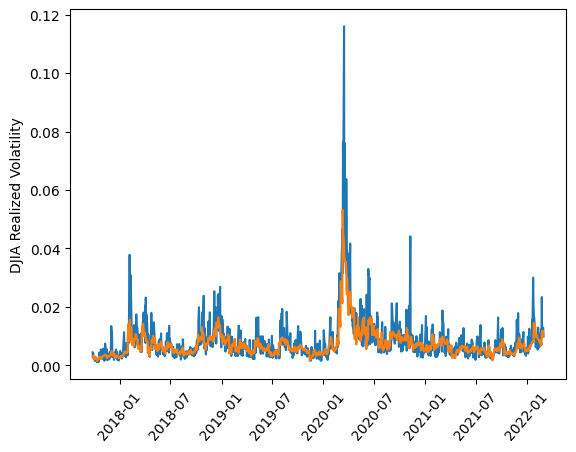

In [ ]:
plt.plot(forecasts["ds"], Y_true)
plt.plot(forecasts["ds"], Y_hat1) 
plt.ylabel("DJIA Realized Volatility")
plt.xticks(rotation=50)
plt.show()

In [11]:
Data = {'Date': forecasts["ds"],
        'Actuals': Y_true,
        'Forecast without PH': Y_hat1
        }
df1=pd.DataFrame(data=Data)
df1.to_csv("Forecast without PH (NBEATSx).csv")